In [1]:
import numpy as np
from scipy.stats import gamma
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

In [2]:
%matplotlib notebook

In [3]:
lamb = 10 #The Poisson rate
num_jolts = 20

In [4]:
rg = np.random.default_rng()
jt = rg.exponential(lamb, num_jolts) #The time points where the Gamma jolts start (but the initial one is at zero)

In [5]:
print(jt)

[10.39384574 12.84540048 26.29785189 18.11470359 14.7202766   3.41913555
 12.68308961  0.31821386 18.75194464  6.18473863  5.66724932 27.72132094
  9.06465037  6.13186347  5.79888956 16.22954079  0.6138178  10.68988479
  0.24239769  4.43214411]


In [6]:
L = 2 #length of the spring at equilibrium
m = 0.9 #mass
fri = 0.1 #friction coefficient
k = 1.2 #spring constant
n = 200 #number of evaluation points between jolts

In [7]:
class Slopy:
    
    def __init__(self, shape, rate, t_init, t_fini, state0):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0
        
        
    def set_param(self, shape, rate, t_init, t_fini, state0):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0

    def der_state(self, t, state):
        der = np.zeros_like(state)
        der[0] = state[1]
        der[1] = -(fri/m)*state[1] - (k/m)*state[0] + gamma.pdf(t, self.shape, self.ti, self.rate)
        return der
    
    def solo(self):
        sol = integrate.solve_ivp(self.der_state, (self.ti, self.tf), self.s0, t_eval=T)
        return sol
    
    def forcer(self, t):
        jolt = gamma.pdf(t, self.shape, self.ti, self.rate)
        return jolt

In [8]:
state0 = ([0, 0]) #this is the initial state

In [9]:
for i in range(num_jolts):
    shape = rg.uniform(1, 6)
    rate = rg.uniform(0.2, 6)
    if i == 0:
        ti = 0
        tf = jt[0]
        sloper = Slopy(shape,rate,ti,tf,state0)
    else:
        ti = tf
        tf = ti + jt[i]
        sloper.set_param(shape,rate,ti,tf,state0)
    dt = (tf-ti)/n
    T = np.linspace(ti, tf, n+1)
    
    sol = sloper.solo()
    state0 = [sol.y[0][-1], sol.y[1][-1]]
    drive = sloper.forcer(T)
    
    if i == 0:
        position = sol.y[0]
        time_grid = sol.t
        force = drive
    else:
        position = np.concatenate((position, sol.y[0][1:]), axis=0)
        time_grid = np.concatenate((time_grid, sol.t[1:]), axis=0)
        force = np.concatenate((force, drive[1:]), axis=0)

<IPython.core.display.Javascript object>


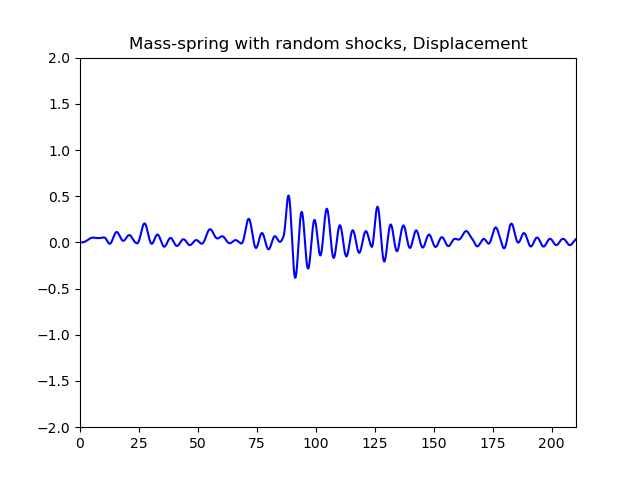

In [10]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-2, 2))
plt.plot(time_grid, position, 'b')
plt.title('Mass-spring with random shocks, Displacement')
plt.show()

<IPython.core.display.Javascript object>


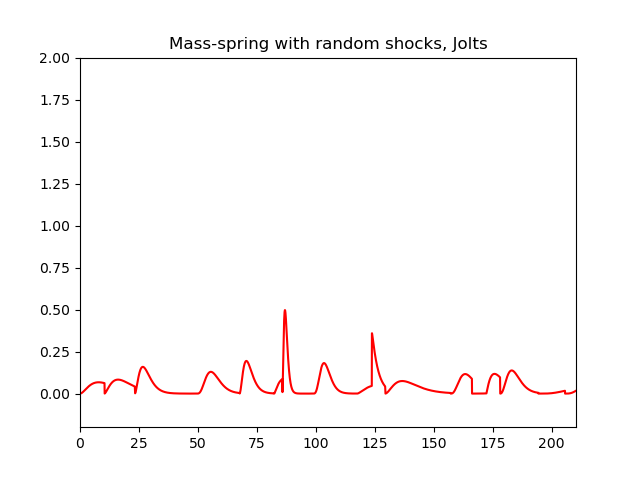

In [11]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-0.2, 2))
plt.plot(time_grid, force, 'r')
plt.title('Mass-spring with random shocks, Jolts')
plt.show()

In [12]:
# The time grid is not uniform so to show an animation we must interpolate
f = interpolate.interp1d(time_grid, position, kind='cubic')
T_uni = np.linspace(time_grid[0], time_grid[-1], time_grid.size)
pose = f(T_uni)
udt = (time_grid[-1]-time_grid[0])/(time_grid.size-1)

In [13]:
time_grid[-1]

210.32095941775196

<IPython.core.display.Javascript object>


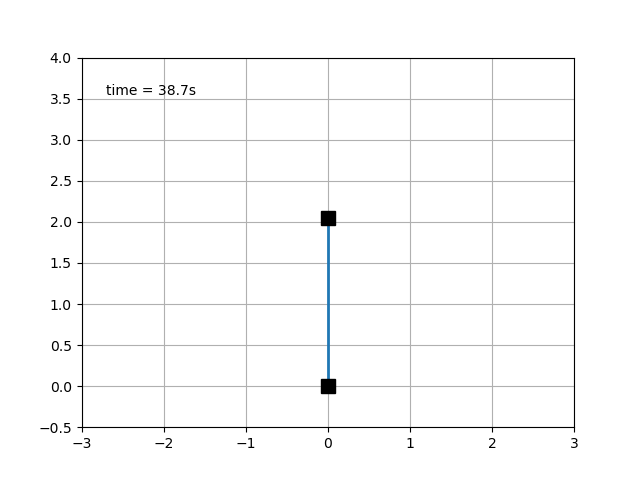

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, xlim=(-L-1, L+1), ylim=(-0.5, L+2))
ax.grid()
ax.set_aspect('equal', adjustable='box')

line, = ax.plot([], [], 's-', markersize = 10, markerfacecolor = 'k', markeredgecolor = 'k', lw=2)
time_template = 'time = '
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisy = [0, L + pose[i]] #this spring is anchored at (0,0)
    anchor = [0, 0]

    line.set_data(anchor, thisy)
    time_text.set_text(time_template + '{:4.1f}'.format(i*udt) + 's')
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(T_uni)),
                              interval=20, blit=True, init_func=init)